In [209]:
import numpy as np
import math as math
import scipy as sc
import pandas as pd
import matplotlib as mt
import matplotlib.pyplot as plt
import seaborn as sns
#import sklearn as sk

# Fáza 3
Autori: Jakub Smorada, Adrian Szacsko
Podiel práce: 50 % / 50 %

Na začiatku je potrebné načítať dáta, ktoré sme uložili na konci fázy 2.

In [210]:
test_dataset = pd.read_csv("faza2/test_dataset.csv", delimiter=",")
train_dataset = pd.read_csv("faza2/train_dataset.csv", delimiter=",")

test_dataset.drop(test_dataset.columns[0], axis=1, inplace=True)
train_dataset.drop(train_dataset.columns[0], axis=1, inplace=True)

Vyberieme len tie atribúty, ktoré majú najväčší vplyv na indikator.

In [211]:
train_attributes_dataset = train_dataset[['trombocyty','erytrocyty','alt','hematokrit','leukocyty', 'indicator']].copy()
test_attributes_dataset = test_dataset[['trombocyty','erytrocyty','alt','hematokrit','leukocyty', 'indicator']].copy()
train_attributes_dataset

,trombocyty,erytrocyty,alt,hematokrit,leukocyty,indicator
0,0.000000,0.657410,0.590051,0.124012,0.235670,0.0
1,0.472369,0.783140,0.756626,0.916138,0.979337,0.0
2,0.000000,0.758214,0.765718,0.618083,0.534911,0.0
3,0.520432,0.496035,0.358712,0.899930,0.451250,0.0
4,0.057209,0.578113,0.505168,0.612411,0.582834,0.0
...,...,...,...,...,...,...
7765,0.000000,0.928649,0.926709,0.605019,0.800762,0.0
7766,0.770651,0.490583,0.483083,0.462006,0.570330,1.0
7767,0.606216,0.793698,0.777088,0.000000,0.286733,1.0
7768,0.655724,0.680117,0.607614,0.065900,0.921863,1.0


## 1. Manuálne vytvorenie a vyhodnotenie rozhodovacích pravidiel pre klasifikáciu

<AxesSubplot:xlabel='indicator', ylabel='trombocyty'>

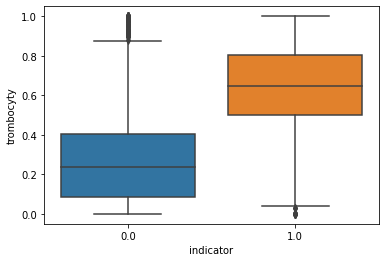

In [212]:
sns.boxplot(data=train_attributes_dataset, x="indicator", y="trombocyty")

In [213]:
from quick_sort import quickSort
from math import ceil

def oneR_model(dataset:pd.DataFrame, attribute):
    rows = len(dataset)
    percent = ceil(rows*0.3)
    min = 0
    max = 0
    zero_array = []
    one_array = []
    for i in range(rows):
        if dataset["indicator"][i] == 0:
            zero_array.append(dataset[attribute][i])
        else:
            one_array.append(dataset[attribute][i])

    quickSort(one_array, 0, len(one_array)-1)
    quickSort(zero_array, 0, len(zero_array)-1)
    zero_array = zero_array[::-1]

    if percent > len(one_array):
        percent = len(one_array)
    if percent > len(zero_array):
        percent = len(zero_array)

    for i in range(percent):
        min += one_array[i]
        max += zero_array[i]

    min = min/percent
    max = max/percent

    threshold = (min+max)/2
    return threshold


def oneR(model, dataset_attr):
    predict = []
    for i in dataset_attr:
        if i > model:
            predict.append(1)
        else:
            predict.append(0)
    return predict


Trombocyty, Erytrocyty, Alt, Hematokrit a Leukocyty

In [214]:
model = oneR_model(train_attributes_dataset, "trombocyty")
oneR_prediction = oneR(model, train_attributes_dataset["trombocyty"])

In [215]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def evaluation(output, prediction):
    print("Accuracy:",accuracy_score(output, prediction))
    print("Precision:",precision_score(output, prediction, average='macro'))
    print("Recall:",recall_score(output, prediction, average='macro'))

In [216]:
print("\nTrenovaci dataset:")
evaluation(train_attributes_dataset["indicator"], oneR_prediction)
oneR_prediction_test = oneR(model, test_attributes_dataset["trombocyty"])
print("\nTestovaci dataset:")
evaluation(test_attributes_dataset["indicator"], oneR_prediction_test)


Trenovaci dataset:
Accuracy: 0.8223938223938224
Precision: 0.8083146067415731
Recall: 0.8023544689740839

Testovaci dataset:
Accuracy: 0.8111168296448791
Precision: 0.7943753597467383
Recall: 0.7856402326214595


## 2. Natrénovanie a vyhodnotenie klasifikátora strojového učenia


Rozdelíme datasety z trénovacej a testovacej na trénovací vstup, trénovací výstup, testovací vstup a testovací výstup
pre vyhodnotenie UI algoritmov

In [217]:
train_attributes_dataset_input = train_attributes_dataset.drop(columns=["indicator"])
train_attributes_dataset_output = train_attributes_dataset["indicator"].copy()

test_attributes_dataset_input = test_attributes_dataset.drop(columns=["indicator"])
test_attributes_dataset_output = test_attributes_dataset["indicator"].copy()


Vytvoríme model pre náš dataset podľa trénovacej množiny a vyzualizujeme natrénované pravidlá

Tree model:


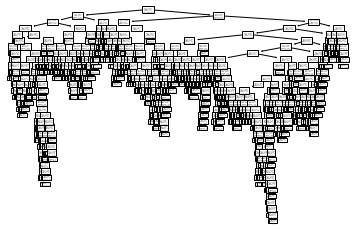

In [218]:
from sklearn import tree
import graphviz
tree_model = tree.DecisionTreeClassifier()

tree_model = tree_model.fit(train_attributes_dataset_input, train_attributes_dataset_output)

tree.plot_tree(tree_model)
print("Tree model:")

Pomocou vytvorenej tree_model predikujeme indikátor na trénovacej a na testovacej množine

In [219]:
tree_train_output = tree_model.predict(train_attributes_dataset_input)
print("Trenovaci dataset:")
evaluation(train_attributes_dataset_output, tree_train_output)
print("\nTestovaci dataset:")
tree_test_output = tree_model.predict(test_attributes_dataset_input)
evaluation(test_attributes_dataset_output, tree_test_output)

Trenovaci dataset:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Testovaci dataset:
Accuracy: 0.925887802367473
Precision: 0.9195586807221163
Recall: 0.9172583433982374


Vidíme, že náš tree_model vedel odhadnúť priemerne 92% hodnôt indikátoru podľa zadaných atribútov

Pri porovnaní nášho OneR predikciu s tree_model predikciou vidíme, že stromový algoritmus vyhodnotil priemerne o 10%
lepšie indikátor ako náš algoritmus. To je možné z dôvodu, že náš OneR algoritmus pracuje len s jedným atribútom, kým
stromový algoritmus s piatimi.

In [220]:
evaluation(test_attributes_dataset["indicator"], oneR_prediction_test)


Accuracy: 0.8111168296448791
Precision: 0.7943753597467383
Recall: 0.7856402326214595
